# Importar Librerías

In [53]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate


# Ordenar Columnas

In [54]:
df = pd.read_excel("BaseDeDatosFinal(Demográficos+Test).xlsx") 
df.columns = df.columns.str.strip()

# Creamos la Matriz de Correlación 
## Comparando solo Datos Demográficos con los Resultados Totales y Subescalas
## Remarcando con un rectángulo negro la Zona de Interés

In [55]:
df["Genero"] = df["Genero"].str.lower()

# Diccionario de mapeo
mapeo_genero = {
    "masculino": "Masculino",
    "masculino ": "Masculino",
    "hombre": "Masculino",
    "masculina": "Masculino",
    "femenino": "Femenino",
    "femenino ": "Femenino",
    "femenini": "Femenino",
    "femenina": "Femenino",
    "femenina ": "Femenino",
    "mujer": "Femenino"
}

# Aplicar reemplazo
df["Genero"] = df["Genero"].replace(mapeo_genero)

# Revisar los nuevos conteos
df["Genero"].value_counts()

Genero
Femenino     128
Masculino     88
Name: count, dtype: int64

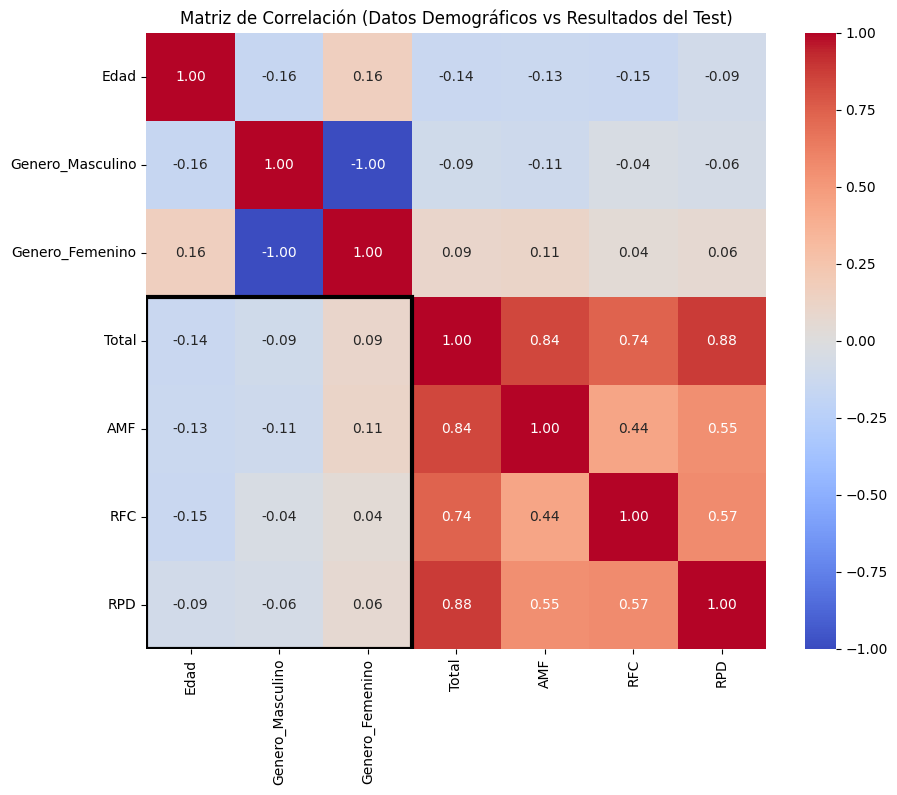

In [62]:

# Código previo
df_dummies = pd.get_dummies(df)
datos_demograficos = ['Edad', 'Genero_Masculino','Genero_Femenino']
resultados_test = ['Total', 'AMF', 'RFC','RPD']

df_seleccionado = df_dummies[datos_demograficos + resultados_test]
corr_matrix = df_seleccionado.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f')

# Identificar las posiciones de las filas/columnas a remarcar
start_row = corr_matrix.index.get_loc("Total")
end_row = corr_matrix.index.get_loc("RPD")
start_col = corr_matrix.columns.get_loc("Edad")
end_col = corr_matrix.columns.get_loc("Genero_Femenino")

# Dibujar un rectángulo negro alrededor de la sección seleccionada
plt.gca().add_patch(plt.Rectangle((start_col, start_row), end_col - start_col + 1, end_row - start_row + 1, 
                                  fill=False, edgecolor='black', linewidth=3))

plt.title('Matriz de Correlación (Datos Demográficos vs Resultados del Test)')
plt.show()



# Filtrar la matriz de correlación para ver las mayores correlaciones

In [63]:
corr_filtrada = corr_matrix.loc[datos_demograficos, resultados_test]

# Convertir la matriz filtrada a formato largo (long format) para ordenarla
corr_larga = corr_filtrada.stack().reset_index()
corr_larga.columns = ['Datos Demográficos', 'Resultados Test', 'Correlación']

# Tomar el valor absoluto de las correlaciones
corr_larga['Correlación'] = corr_larga['Correlación'].abs()

# Crear una nueva columna de polaridad
corr_larga['Polaridad'] = corr_larga['Correlación'].apply(lambda x: '+' if x > 0 else '-')

# Ordenar las correlaciones en orden descendente por el valor absoluto
top_20 = corr_larga.sort_values(by='Correlación', ascending=False).head(20).reset_index(drop=True)

top_20


,Datos Demográficos,Resultados Test,Correlación,Polaridad
0,Edad,RFC,0.146841,+
1,Edad,Total,0.144905,+
2,Edad,AMF,0.133280,+
3,Genero_Masculino,AMF,0.114520,+
4,Genero_Femenino,AMF,0.114520,+
5,Genero_Masculino,Total,0.094402,+
6,Genero_Femenino,Total,0.094402,+
7,Edad,RPD,0.093742,+
8,Genero_Femenino,RPD,0.062739,+
9,Genero_Masculino,RPD,0.062739,+


# Creamos una Distribución Normal
### Demarcada con la Escala de Burnout Equilibra

C:\Users\gonza\AppData\Local\Temp\ipykernel_21432\116454669.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  total_area, _ = integrate.quad(lambda z: np.interp(z, x, y), 0, 80, limit=200)
C:\Users\gonza\AppData\Local\Temp\ipykernel_21432\116454669.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  segment_area, _ = integrate.quad(lambda z: np.interp(z, x, y), start, end, limit=200)


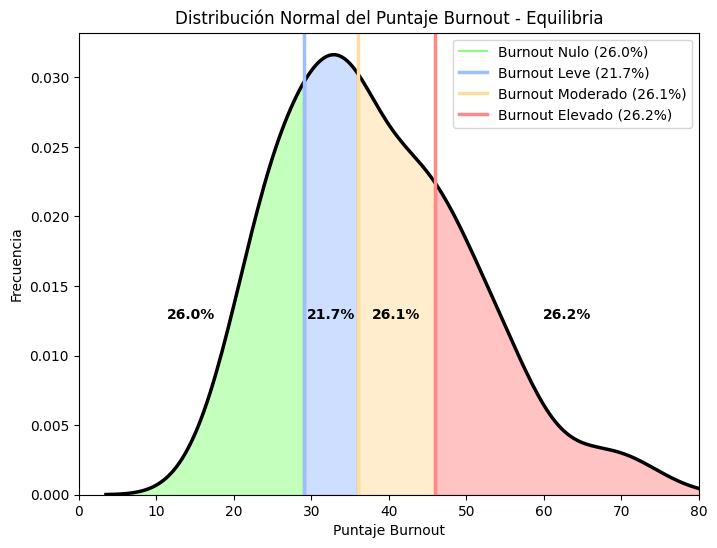

In [65]:
plt.figure(figsize=(8, 6))

# Calcular la curva de densidad
kde = sns.kdeplot(df["Total"], color="black", linewidth=2.5, clip=(0, 80))

# Obtener los datos de la curva
x = kde.get_lines()[0].get_xdata()
y = kde.get_lines()[0].get_ydata()

# Definir los límites de cada segmento y colores
segments = [(0, 29, '#8bff7d', 'Burnout Nulo'),
            (29, 36, '#9dbfff', 'Burnout Leve'),
            (36, 46, '#ffdd9d', 'Burnout Moderado'),
            (46, 80, '#ff8989', 'Burnout Elevado')]

# Calcular el área total bajo la curva
total_area, _ = integrate.quad(lambda z: np.interp(z, x, y), 0, 80, limit=200)

# Rellenar las áreas y calcular los porcentajes
for start, end, color, label in segments:
    plt.fill_between(x, y, where=(x > start) & (x <= end), color=color, alpha=0.5)
    
    # Calcular el área del segmento
    segment_area, _ = integrate.quad(lambda z: np.interp(z, x, y), start, end, limit=200)

    percentage = (segment_area / total_area) * 100
    
    # Mostrar el porcentaje en el centro del área
    plt.text((start + end) / 2, max(y) * 0.4, f'{percentage:.1f}%', 
             color='black', ha='center', fontsize=10, fontweight='bold')
    
    # Agregar la leyenda con el porcentaje
    if start != 0:
        plt.axvline(x=start, color=color, linestyle='-', linewidth=2.5, 
                    label=f'{label} ({percentage:.1f}%)')
    else:
        plt.plot([], [], color=color, label=f'{label} ({percentage:.1f}%)')  # Sin línea visible

plt.xlim(0, 80)  # Limitar eje X de 0 a 80
plt.title("Distribución Normal del Puntaje Burnout - Equilibria")
plt.xlabel("Puntaje Burnout")
plt.ylabel("Frecuencia")
# plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()




# Creamos un Histograma para ver que variables (Subescalas) influyen en el resultado del Burnout

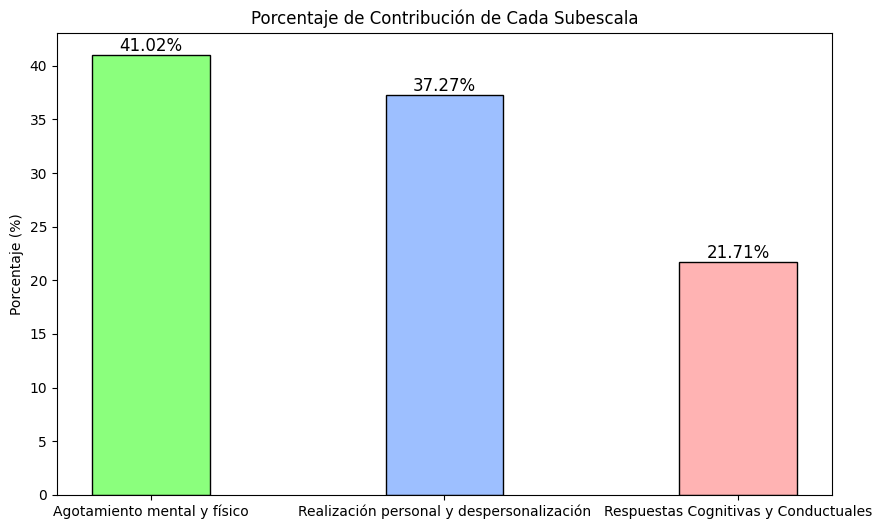

In [68]:
promedios = {
    "Agotamiento mental y físico": df[["AMF"]].mean()[0],
    "Realización personal y despersonalización": df[["RPD"]].mean()[0],
    "Respuestas Cognitivas y Conductuales": df[["RFC"]].mean()[0]
}

# Calculamos el porcentaje de cada una de las variables
porcentajes = {key: (value / (df[["Total"]].mean()[0])) * 100 for key, value in promedios.items()}

# Graficar el histograma con los porcentajes
plt.figure(figsize=(10, 6))
bars = plt.bar(porcentajes.keys(), porcentajes.values(), 
               color=["#8bff7d", "#9dbfff", "#ffb3b3"], 
               width=0.4, 
               edgecolor="black")  # Borde negro

# Añadir los porcentajes dentro de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title("Porcentaje de Contribución de Cada Subescala")
plt.ylabel("Porcentaje (%)")
plt.show()
